<a href="https://colab.research.google.com/github/KyungRyeolBaek/study/blob/main/ErrorCorr_f(xy)_21_08_08_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Error Corr

import

In [1]:
import autograd.numpy as np
from autograd import grad 
import autograd.numpy.random as npr
from autograd.core import primitive
from matplotlib import pyplot as plt
%matplotlib inline

using GPU

In [2]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
from tensorflow.python.client import device_lib 
device_lib.list_local_devices() 
tf.test.is_gpu_available()
# gpu를 사용하려면 cmd와 jupyter notebook cell에서 모두 True값이 나와야 함

Instructions for updating:
non-resource variables are not supported in the long term
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


False

In [3]:
x_max = 1             # 최대 x 범위 : 0 <= x < x_max
w_number = 6          # w 개수
cost_limit = 0.1      # 최소 cost 
step_number = 30000   # step 횟수

def f(x, y1, y2):          # f(x, y1, y2)
  return [y1, y2]

def anal(x):
  return [np.exp(x), np.exp(x)]

def Error_Corr(x_max = 1, w_number = 6, cost_limt = 0.1, step_number = 30000):
  def sigmoid(x):
      return 1 / (1 + tf.math.exp(-x))

  def sigmoid_grad(x):
      return sigmoid(x) * (1 - sigmoid(x))

  def neural_network(W, x):
      a1 = sigmoid(tf.tensordot(x, W[0], axes = 1))
      return tf.tensordot(a1, W[1], axes = 1)

  def d_neural_network_dx(W, x, k=1):
      return tf.tensordot(tf.transpose(W[1]), tf.transpose(W[0])**k, axes = 1) * sigmoid_grad(x)

  x = tf.Variable(np.array([[i/100] for i in range(0, x_max * 100, 1)], dtype = np.float32))
  W = [tf.Variable(tf.random_normal([1, 10])), tf.Variable(tf.random_normal([10, 1]))]
  B = [tf.Variable(tf.random_normal([1, 10])), tf.Variable(tf.random_normal([10, 1]))]
  for i in range(1, w_number + 1):
      globals()['w{}'.format(i)] = tf.Variable(tf.random_normal([1]), name = 'weight{}'.format(i))
      globals()['b{}'.format(i)] = tf.Variable(tf.random_normal([1]), name = 'bias{}'.format(i))
  y1 = 1
  y1prime = 0
  y2 = 1
  y2prime = 0

  sess = tf.Session()
  init = tf.global_variables_initializer()
  sess.run(init)

  for i in range(1, w_number + 1):
      y1 += globals()['w{}'.format(i)]*(x**i)  # y1 = 1 + w1*(x) + w2*(x**2) + w3*(x**3) + w4*(x**4) + w5*(x**5) + w6*(x**6)
      y1prime += i*globals()['w{}'.format(i)]*(x**(i-1))  # y1prime = w1 + 2*w2*x + 3*w3*(x**2) + 4*w4*(x**3) + 5*w5*(x**4) + 6*w6*(x**5)
      y2 += globals()['b{}'.format(i)]*(x**i)  # y2 = 1 + b1*(x) + b2*(x**2) + b3*(x**3) + b4*(x**4) + b5*(x**5) + b6*(x**6)
      y2prime += i*globals()['b{}'.format(i)]*(x**(i-1))  # y2prime = b1 + 2*b2*x + 3*b3*(x**2) + 4*b4*(x**3) + 5*b5*(x**4) + 6*b6*(x**5)

  ye1 = (x**(w_number + 1)) * neural_network(W, x)
  ye1prime = (w_number + 1) * (x**(w_number))*neural_network(W, x) + (x**(w_number + 1)) * d_neural_network_dx(W, x)
  ye2 = (x**(w_number + 1)) * neural_network(B, x)
  ye2prime = (w_number + 1) * (x**(w_number))*neural_network(B, x) + (x**(w_number + 1)) * d_neural_network_dx(B, x)

  cost = tf.reduce_mean(tf.square(ye1prime - ye1) + tf.square(ye2prime - ye2)) + tf.reduce_mean(tf.square(y1prime - f(x, y1, y2)[0]) + tf.square(y2prime - f(x, y1, y2)[1]))
  optimizer = tf.train.GradientDescentOptimizer(learning_rate = 1e-5)
  train = optimizer.minimize(cost)

  count = 0
  cost_val = 1
  while cost_val > cost_limt:
    global x_space
    global y1_space
    global y2_space
    global ye1_space
    global ye2_space
    global corr_space1
    global corr_space2
    global cost_space

    x_space = []
    y1_space = []
    y2_space = []
    ye1_space = []
    ye2_space = []
    corr_space1 = []
    corr_space2 = []
    cost_space = []

    if count % 1 == 0:
      print("count: ", count)
    for step in range(step_number + 1):
      for i in range(1, w_number + 1):
          globals()['w{}_val'.format(i)] = sess.run([globals()['w{}'.format(i)]])
      cost_val, ye1prime_val, ye2prime_val, ye1_val, ye2_val, y1prime_val, y2prime_val, y1_val, y2_val, x_val, _ = sess.run([cost, ye1prime, ye2prime, ye1, ye2, y1prime, y2prime, f(x, y1, y2)[0], f(x, y1, y2)[1], x, train])
      if count % 1 == 0:
        if step % int(step_number / 2) == 0:
            print('step: ', step, ", Cost: ", cost_val, "\n")
    if count % 1 == 0:
      print("\n")

    count += 1

    x_space += list(x_val)
    corr_space1 += list(ye1_val + y1_val)
    corr_space2 += list(ye2_val + y2_val)
    y1_space += list(y1_val)
    y2_space += list(y2_val)
    ye1_space += list(ye1_val)
    ye2_space += list(ye2_val)

    # final_sol1 = ye1 + y1
    # final_sol2 = ye2 + y2
    # anal_sol1 = anal(x)[0]
    # anal_sol2 = anal(x)[1]
    # error1 = abs(final_sol1 - anal_sol1)
    # error2 = abs(final_sol2 - anal_sol2)
    # print(np.linalg.norm)
    plt.subplot(1, 2, 1)
    plt.plot(x_space, corr_space1, '.', label = 'ye1 + y1')
    plt.plot(x_space, y1_space, '.', label = 'y1')
    plt.plot(x_space, ye1_space, '.', label = 'ye1')
    plt.plot(x_space, anal(x_space)[0], '.', label = 'exp')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x_space, corr_space2, '.', label = 'ye2 + y2')
    plt.plot(x_space, y2_space, '.', label = 'y2')
    plt.plot(x_space, ye2_space, '.', label = 'ye2')
    plt.plot(x_space, anal(x_space)[1], '.', label = 'exp')
    plt.legend()
    plt.show()

  sess.close()

count:  0
step:  0 , Cost:  6.594556 

step:  25000 , Cost:  0.20666134 

step:  50000 , Cost:  0.111606814 





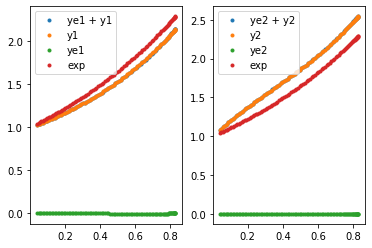

count:  1
step:  0 , Cost:  0.111605234 

step:  25000 , Cost:  0.083484076 

step:  50000 , Cost:  0.066955134 





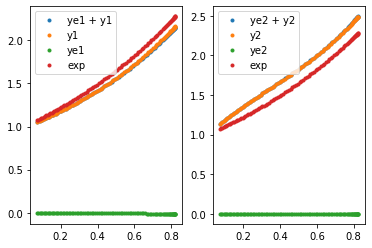

count:  2
step:  0 , Cost:  0.066954605 

step:  25000 , Cost:  0.055759247 

step:  50000 , Cost:  0.047627635 





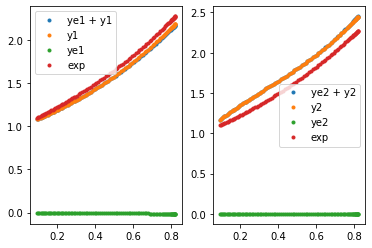

count:  3
step:  0 , Cost:  0.04762736 

step:  25000 , Cost:  0.041577473 

step:  50000 , Cost:  0.03688312 





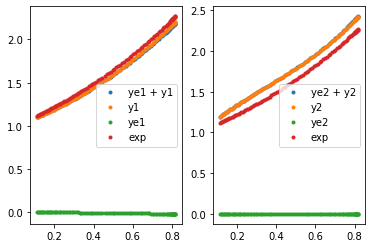

count:  4
step:  0 , Cost:  0.03688295 

step:  25000 , Cost:  0.03311096 

step:  50000 , Cost:  0.030067164 





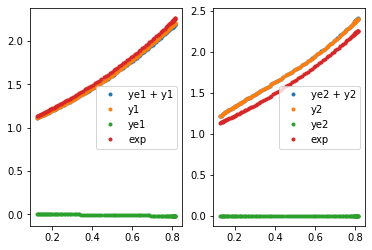

count:  5
step:  0 , Cost:  0.030067047 

step:  25000 , Cost:  0.02754455 

step:  50000 , Cost:  0.0253996 





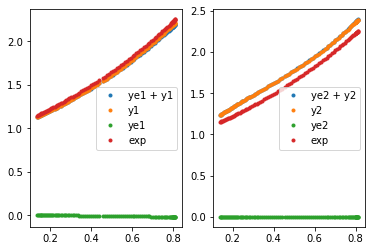

count:  6
step:  0 , Cost:  0.025399523 

step:  25000 , Cost:  0.023546018 

step:  50000 , Cost:  0.021957548 





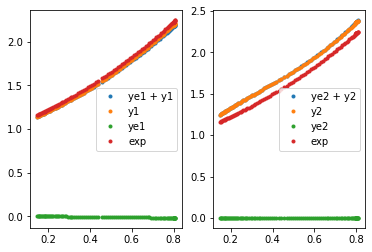

count:  7
step:  0 , Cost:  0.021957494 

step:  25000 , Cost:  0.020538049 

step:  50000 , Cost:  0.019278158 





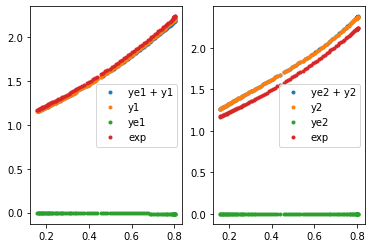

count:  8
step:  0 , Cost:  0.01927811 

step:  25000 , Cost:  0.018137414 

step:  50000 , Cost:  0.01713201 





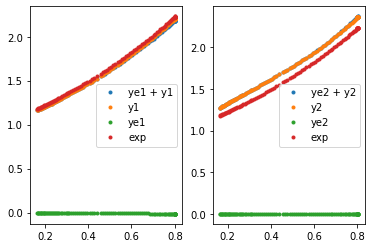

count:  9
step:  0 , Cost:  0.01713197 

step:  25000 , Cost:  0.016245073 

step:  50000 , Cost:  0.015439562 





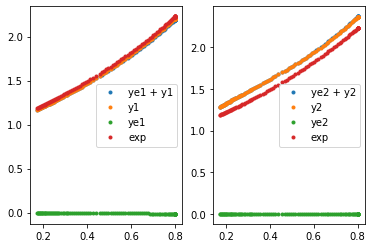

count:  10
step:  0 , Cost:  0.015439528 

step:  25000 , Cost:  0.0146966325 

step:  50000 , Cost:  0.014000915 





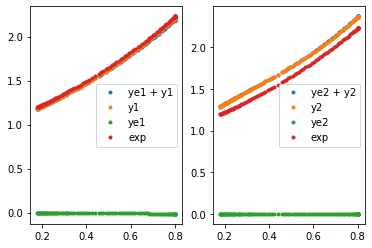

count:  11
step:  0 , Cost:  0.014000894 

step:  25000 , Cost:  0.013346833 

step:  50000 , Cost:  0.01273429 





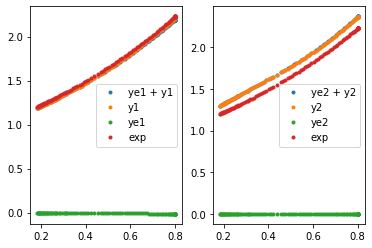

count:  12
step:  0 , Cost:  0.012734259 

step:  25000 , Cost:  0.012155922 

step:  50000 , Cost:  0.011611228 





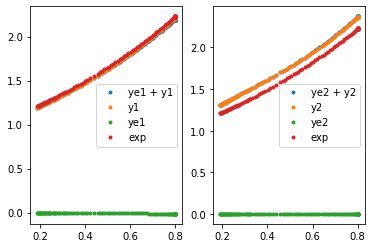

count:  13
step:  0 , Cost:  0.0116112055 

step:  25000 , Cost:  0.011103253 

step:  50000 , Cost:  0.010636908 





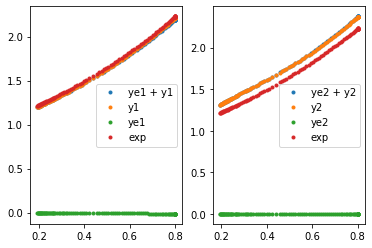

count:  14
step:  0 , Cost:  0.010636894 

step:  25000 , Cost:  0.010200045 

step:  50000 , Cost:  0.009796105 





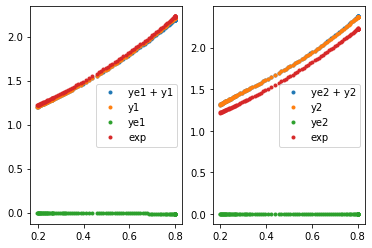

In [4]:
x_max = 1             # 최대 x 범위 : 0 <= x < x_max
w_number = 6          # w 개수
cost_limit = 0.01      # 최소 cost 
step_number = 50000    # step 횟수 -> 총 step 횟수 = count * step

def f(x, y1, y2):          # f(x, y)
  return [y1, y2]

def anal(x):
  return [np.exp(x), np.exp(x)]
  
Error_Corr(x_max, w_number, cost_limit, step_number)

In [5]:
def anal(x):
  return [np.exp(x), np.exp(x)]

error1 = abs(corr_space1 - anal_sol1)
error2 = abs(corr_space2 - anal_sol2)
plt.subplot(1, 2, 1)
plt.plot(x_space, anal(x_space)[0], '.', label = 'anal sol1')
plt.plot(x_space, corr_space1, '.', label = 'final sol1')
plt.plot(x_space, error1, '.', label = 'error1')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(x_space, anal(x_space)[1], '.', label = 'anal sol2')
plt.plot(x_space, corr_space2, '.', label = 'final sol2')
plt.plot(x_space, error2, '.', label = 'error2')
plt.legend()
plt.show()
print(np.linalg.norm(error))

NameError: ignored